In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import pickle
import math
import scipy.optimize as optim
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import covid19_prepare_data as prepare_data

# import logging
# logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [2]:
def fetch_data():
    prepare_data.build_covid19_data()

In [3]:
# Define funcion with the coefficients to estimate
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))

In [4]:
def detect_growth():
    df = pd.read_csv('data/covid19_data.csv', parse_dates=True)
    columns = df.columns.values
    for column in columns:
        if column.endswith('_cases'):
            data = pd.DataFrame(df[column].values)
            
            data = data.reset_index(drop=False)
            data.columns = ['Timestep', 'Total Cases']
            
            # Randomly initialize the coefficients
            p0 = np.random.exponential(size=3)

            # Set min bound 0 on all coefficients, and set different max bounds for each coefficient
            bounds = (0, [100000., 1000., 1000000000.])

            # Convert pd.Series to np.Array and use Scipy's curve fit to find the best Nonlinear Least Squares coefficients
            x = np.array(data['Timestep']) + 1
            y = np.array(data['Total Cases'])
            
            try:
                (a,b,c),cov = optim.curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=1000000)
                
                # The time step at which the growth is fastest
                t_fastest = np.log(a) / b
                i_fastest = func_logistic(t_fastest, a, b, c)
                
                res_df = df[['Report_Date', column]].copy()
                res_df['fastest_grow_day'] = t_fastest
                res_df['fastest_grow_value'] = i_fastest
                res_df['growth_stabilized'] = t_fastest <= x[-1]
                res_df['timestep'] = x
                res_df['res_func_logistic'] = func_logistic(x, a, b, c)

                if t_fastest <= x[-1]:
                    print('Growth stabilized:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
                    res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
                else:
                    print('Growth increasing:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
                    res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)
                
                res_df.to_csv('data/covid19_processed_data_' + column + '.csv')
            except RuntimeError:
                print('No fit found for: ', column)

detect_growth()

Growth increasing: Afghanistan_cases | Fastest grow day: 80.46940327278148 | Infections: 479.6239780640343
Growth stabilized: Albania_cases | Fastest grow day: 67.77136901055937 | Infections: 206.4182352382564
Growth increasing: Algeria_cases | Fastest grow day: 79.79925979092172 | Infections: 1719.108525405134
Growth increasing: Andorra_cases | Fastest grow day: 74.09877518250475 | Infections: 546.2096180553541
Growth increasing: Angola_cases | Fastest grow day: 77.70692791043568 | Infections: 13.74382019150295
Growth increasing: Antigua and Barbuda_cases | Fastest grow day: 74.00758507724215 | Infections: 10.053531495629194
Growth increasing: Argentina_cases | Fastest grow day: 78.3958954132719 | Infections: 2050.1958597224984
Growth increasing: Armenia_cases | Fastest grow day: 72.90116026505119 | Infections: 676.8429335798368
Growth increasing: Australia_australian capital territory_cases | Fastest grow day: 74.46175318538447 | Infections: 122.58832340164275
Growth increasing: Aust

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


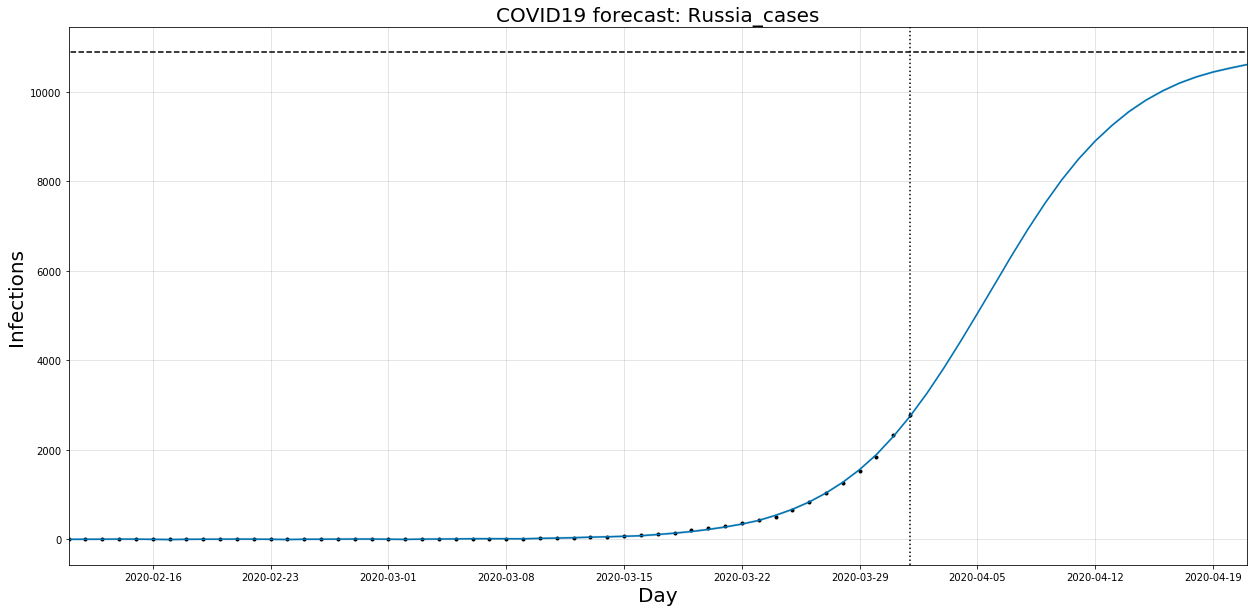

           ds          yhat    yhat_lower    yhat_upper
76 2020-04-07   6323.600493   6306.429258   6340.634353
77 2020-04-08   6933.909275   6916.101873   6950.069308
78 2020-04-09   7506.557272   7487.722409   7522.967697
79 2020-04-10   8032.106619   8015.106918   8048.923704
80 2020-04-11   8498.950688   8481.950038   8516.279650
81 2020-04-12   8906.251420   8887.274634   8922.966318
82 2020-04-13   9255.604361   9237.824072   9272.584391
83 2020-04-14   9561.545029   9543.924706   9579.035757
84 2020-04-15   9814.798223   9797.250520   9833.581165
85 2020-04-16  10024.822121  10006.575353  10042.379936
86 2020-04-17  10198.686015  10181.609727  10215.827246
87 2020-04-18  10336.985762  10319.141364  10354.725435
88 2020-04-19  10446.670156  10430.240108  10462.927509
89 2020-04-20  10533.196209  10514.697570  10551.272620
90 2020-04-21  10611.854772  10594.315432  10628.050865


In [7]:
def build_model(country):
    df = pd.read_csv('data/covid19_processed_data_' + country + '.csv', parse_dates=True)
    df = df[['Report_Date', country, 'cap']].dropna()
    
    df.columns = ['ds', 'y', 'cap']
    
    m = Prophet(growth="logistic")
    m.fit(df)

    future = m.make_future_dataframe(periods=20)
    future['cap'] = df['cap'].iloc[0]

    forecast = m.predict(future)
    
    fig1 = m.plot(forecast)
    fig1.set_size_inches(18.5, 8.5)
    datenow = datetime(2020, 4, 1)
    dateend = datenow + timedelta(days=20)
    datestart = dateend - timedelta(days=70)
    plt.xlim([datestart, dateend])
    plt.title("COVID19 forecast: " + country, fontsize=20)
    plt.xlabel("Day", fontsize=20)
    plt.ylabel("Infections", fontsize=20)
    plt.axvline(datenow, color="k", linestyle=":")
    plt.show()
    
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15))
    
build_model('Russia_cases')